In [3]:
import csv

import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [12]:
#dataset_joren = 'camara_data/hand_landmarks_joren_family.csv'
#dataset_joren_grandparents = 'camara_data/hand_landmarks_moeke.csv'
dataset_testGood = 'camera_data_test/hand_landmarks_goodTest.csv'
dataset_testBad = 'camera_data_test/hand_landmarks_badTest.csv'
dataset_testDark = 'camera_data_test/hand_landmarks_darkTest.csv'
model_save_path = 'new_hand_classifier.keras'
tflite_save_path = 'new_hand_classifier.tflite'

# Set number of classes

In [13]:
NUM_CLASSES = 26

# Dataset reading

In [14]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1))))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data, axis=0)
X_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [15]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
y_dataset = np.concatenate(data, axis=0)
y_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='int32', usecols=(0))
y_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='int32', usecols=(0))
y_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='int32', usecols=(0))

In [16]:
print("X_dataset shape: " + X_dataset.shape.__str__())
print("y_dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X_test_dataset_good shape: " + X_testGood.shape.__str__())
print("y_test_dataset_good shape: " + y_testGood.shape.__str__())
print("----------------------------------")
print("X_test_dataset_bad shape: " + X_testBad.shape.__str__())
print("y_test_dataset_bad shape: " + y_testBad.shape.__str__())
print("----------------------------------")
print("X_test_dataset_dark shape: " + X_testDark.shape.__str__())
print("y_test_dataset_dark shape: " + y_testDark.shape.__str__())


X_dataset shape: (28799, 42)
y_dataset shape: (28799,)
----------------------------------
X_test_dataset_good shape: (2400, 42)
y_test_dataset_good shape: (2400,)
----------------------------------
X_test_dataset_bad shape: (2400, 42)
y_test_dataset_bad shape: (2400,)
----------------------------------
X_test_dataset_dark shape: (2400, 42)
y_test_dataset_dark shape: (2400,)


In [17]:
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

In [18]:
print(X_train)

[[ 0.          0.          0.41489363 ...  0.5053192   0.2393617
   0.3617021 ]
 [ 0.          0.         -0.2857143  ... -0.584127   -0.3968254
  -0.45079365]
 [ 0.          0.          0.05701754 ...  0.0877193  -0.05263158
   0.1008772 ]
 ...
 [ 0.          0.          0.21645021 ... -0.47619048 -0.08658009
  -0.4025974 ]
 [ 0.          0.         -0.23004694 ... -0.53521127 -0.53521127
  -0.47887325]
 [ 0.          0.         -0.2021858  ... -0.45628417  0.30054644
  -0.45901638]]


# Model building

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_validation_selected = selector.transform(X_validation)

# Get feature scores
feature_scores = selector.scores_

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Print feature scores and their corresponding indices
for i, score in enumerate(feature_scores):
    if i in selected_indices:
        print(f"Feature {i}: Score = {score}")

Feature 0: Score = nan
Feature 1: Score = nan
Feature 2: Score = 2.2616844177246094
Feature 3: Score = 1422.3675537109375
Feature 4: Score = 3.096345901489258
Feature 5: Score = 1785.33154296875
Feature 6: Score = 4.277293682098389
Feature 7: Score = 1984.53369140625
Feature 8: Score = 4.322386264801025
Feature 9: Score = 2045.102294921875
Feature 10: Score = 10.171741485595703
Feature 11: Score = 979.0191650390625
Feature 12: Score = 7.293735980987549
Feature 13: Score = 1915.3621826171875
Feature 14: Score = 5.476755142211914
Feature 15: Score = 2621.005615234375
Feature 16: Score = 5.073232650756836
Feature 17: Score = 3402.20458984375
Feature 18: Score = 18.33689308166504
Feature 19: Score = 872.2612915039062
Feature 20: Score = 11.004868507385254
Feature 21: Score = 2164.6123046875
Feature 22: Score = 7.783453941345215
Feature 23: Score = 3030.634765625
Feature 24: Score = 6.933218002319336
Feature 25: Score = 3796.509521484375
Feature 26: Score = 21.700401306152344
Feature 27: Sc

C:\thesis\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\thesis\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\thesis\venv\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 21, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 2, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 2, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,618 (1.92 MB)

 Trainable params: 502,618 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [23]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [24]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
154/158 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2756 - loss: 2.3736
Epoch 1: saving model to new_hand_classifier.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2826 - loss: 2.3485 - val_accuracy: 0.8324 - val_loss: 0.5163
Epoch 2/1000
154/158 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8176 - loss: 0.5303
Epoch 2: saving model to new_hand_classifier.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8183 - loss: 0.5282 - val_accuracy: 0.9216 - val_loss: 0.2496
Epoch 3/1000
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8869 - loss: 0.3169
Epoch 3: saving model to new_hand_classifier.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8870 - loss: 0.3165 - val_accuracy: 0.9510 - val_loss: 0.1478
Epoch 4/1000
156/158 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9263 - loss: 0.2167
Epoch 4: saving model to new_hand_classifier.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9265 - loss: 0.2162 - val_accu

In [25]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testGood, y_testGood, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9961 - loss: 0.0124


In [26]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testBad, y_testBad, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8374 - loss: 1.6085


In [27]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testDark, y_testDark, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9061 - loss: 1.0658


In [20]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [21]:
# Inference test
predict_result = model.predict(np.array([X_testGood[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[1.0000000e+00 1.9761846e-37 1.0251093e-23 3.9486502e-25 1.1877628e-34
 0.0000000e+00 1.2039201e-27 5.1719514e-37 1.8141963e-37 4.9285040e-38
 3.5344669e-29 2.2631324e-22 9.4457814e-21 5.7227818e-27 9.6158925e-36
 4.3676673e-28 6.2733252e-17 2.2850454e-37 3.3819247e-30 1.2565173e-23
 0.0000000e+00 3.2607032e-36 2.1667505e-21 8.7476595e-28 1.5995492e-13
 0.0000000e+00]
0


# Confusion matrix

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


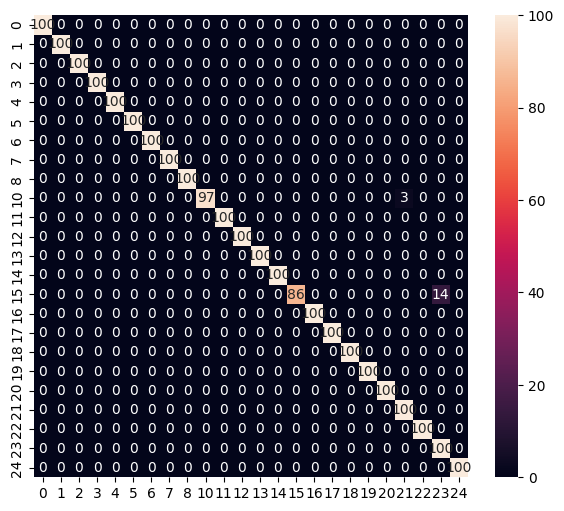

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
          10       1.00      0.97      0.98       100
          11       1.00      1.00      1.00       100
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00       100
          14       1.00      1.00      1.00       100
          15       1.00      0.86      0.92       100
          16       1.00      1.00      1.00       100
          17       1.00      1.00      1.00       100
     

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_testGood, y_pred))

Y_pred = model.predict(X_testGood)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_testGood, y_pred)

# Convert to model for Tensorflow-Lite

In [23]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [1]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

NameError: name 'tf' is not defined

# Inference test

In [2]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

NameError: name 'tf' is not defined

In [4]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

NameError: name 'interpreter' is not defined

In [5]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_testGood[0]]))

NameError: name 'interpreter' is not defined

In [6]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

NameError: name 'interpreter' is not defined

In [7]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

NameError: name 'tflite_results' is not defined

In [8]:
# Save the model
model.save(model_save_path, include_optimizer=False)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Write the TFLite file
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

NameError: name 'model' is not defined

#### Loss  (cost)

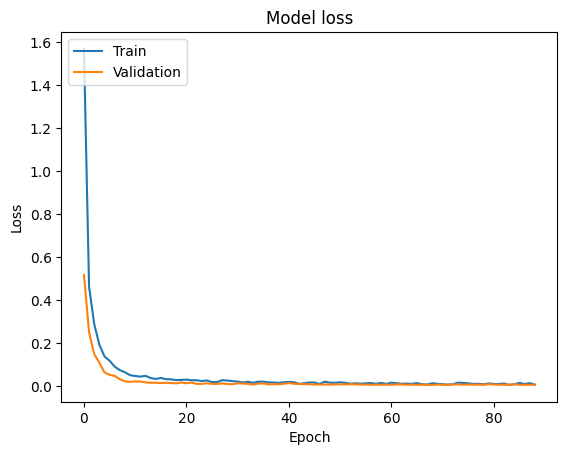

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

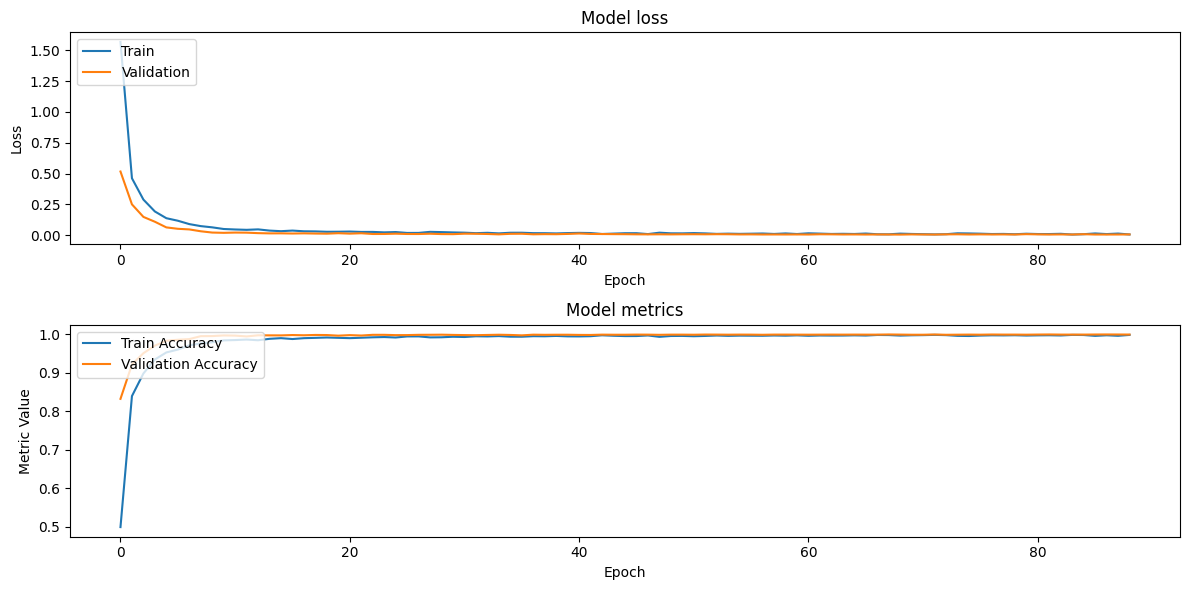

In [30]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

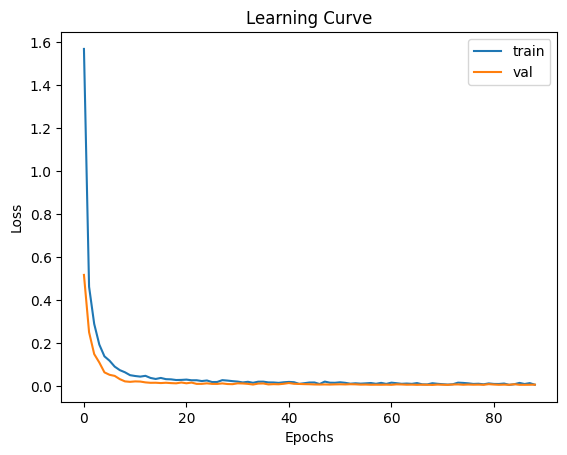

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()